In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Uvelka/FE')

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
DATAPAH = '/content/drive/MyDrive/Colab Notebooks/Uvelka/Data/'

In [7]:
df = pd.read_csv(DATAPAH + 'concat_data.csv', date_format = "%d/%m/%Y", parse_dates=['Дата/Время'], decimal = ',', dayfirst=True).iloc[:-1 , :]

In [8]:
df_copy = df.copy()

In [93]:
df_copy_5k = df_copy.iloc[-5000:,:].reset_index().copy()

In [94]:
from statsmodels.tsa.arima.model import ARIMA

# Подготовка данных
train_data = df_copy_5k['Токовый ремни Афл3.1.Максим RMS'].dropna()
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Предсказание пропусков
forecast = model_fit.predict(start=0, end=len(df_copy_5k)-1, typ='levels')
df_copy_5k['Токовый ремни Афл3.1.Максим RMS'].fillna(pd.Series(forecast), inplace=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

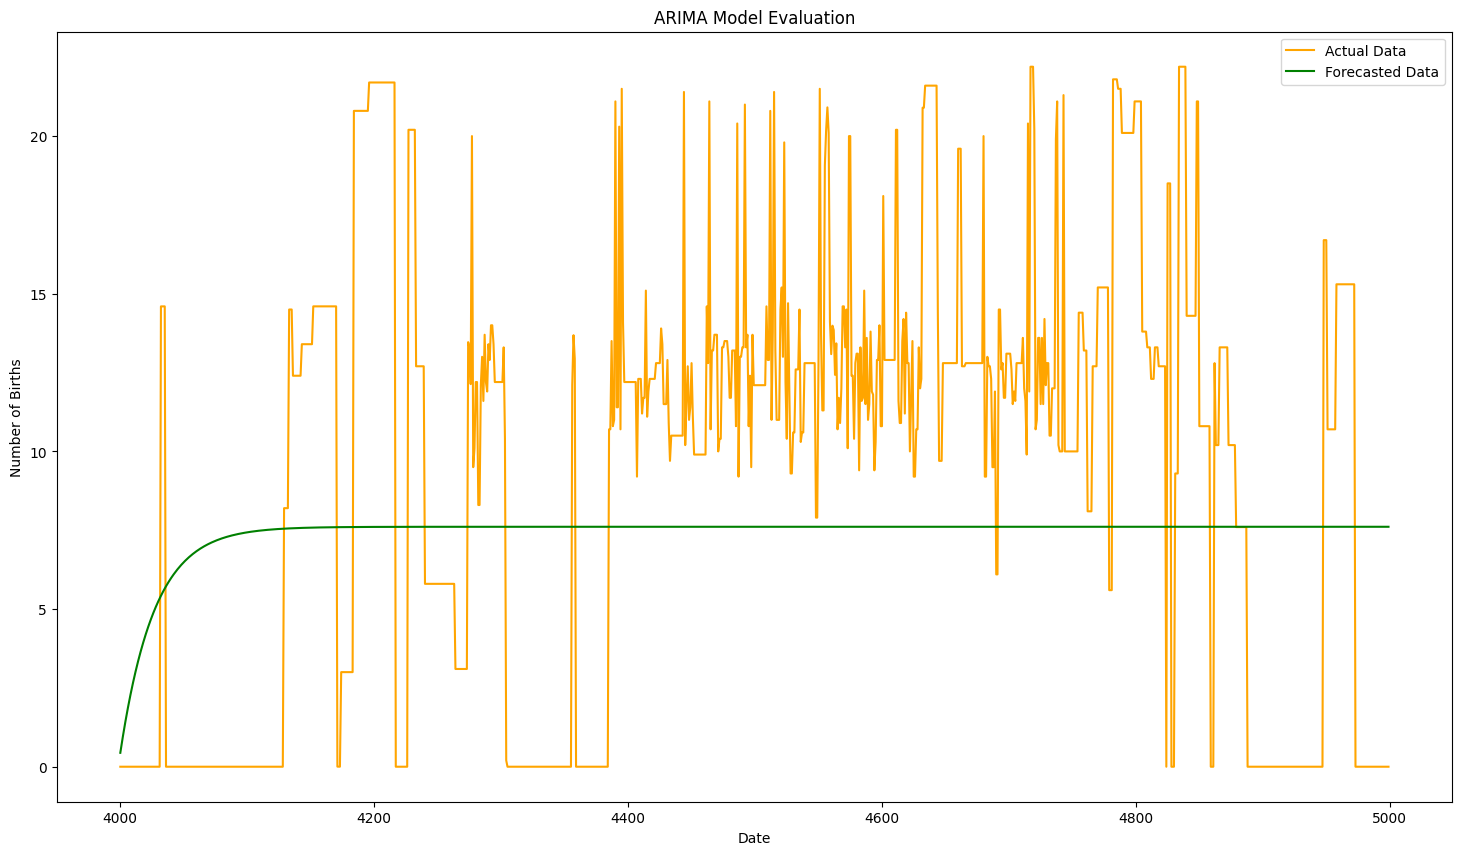

MAE: 6.329805040598159


In [243]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Split the data into train and test
train_size = int(len(df_copy_5k['Токовый ремни Афл3.1.Максим RMS']) * 0.8)
train, test = df_copy_5k['Токовый ремни Афл3.1.Максим RMS'][0:train_size], df_copy_5k['Токовый ремни Афл3.1.Максим RMS'][train_size:len(df_copy_5k['Токовый ремни Афл3.1.Максим RMS'])]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train, order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mae = mean_absolute_error(test, test_forecast_series)
#rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(18,10))
#plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

print('MAE:', mae)

In [262]:
# Anomaly detection (naive)
# Расхождение с моделью

# Подбор порога - ско от остатков
data_pr = pd.DataFrame()

data_pr['e'] = test - test_forecast_series

threshold = 2 * np.std(data_pr['e'])



In [263]:
# Поиск значений выходящих за порог и отнесение в аномалии
data_pr['anomaly'] = np.where(np.abs(data_pr['e']) > threshold, 1, 0)
data_pr['y'] = test

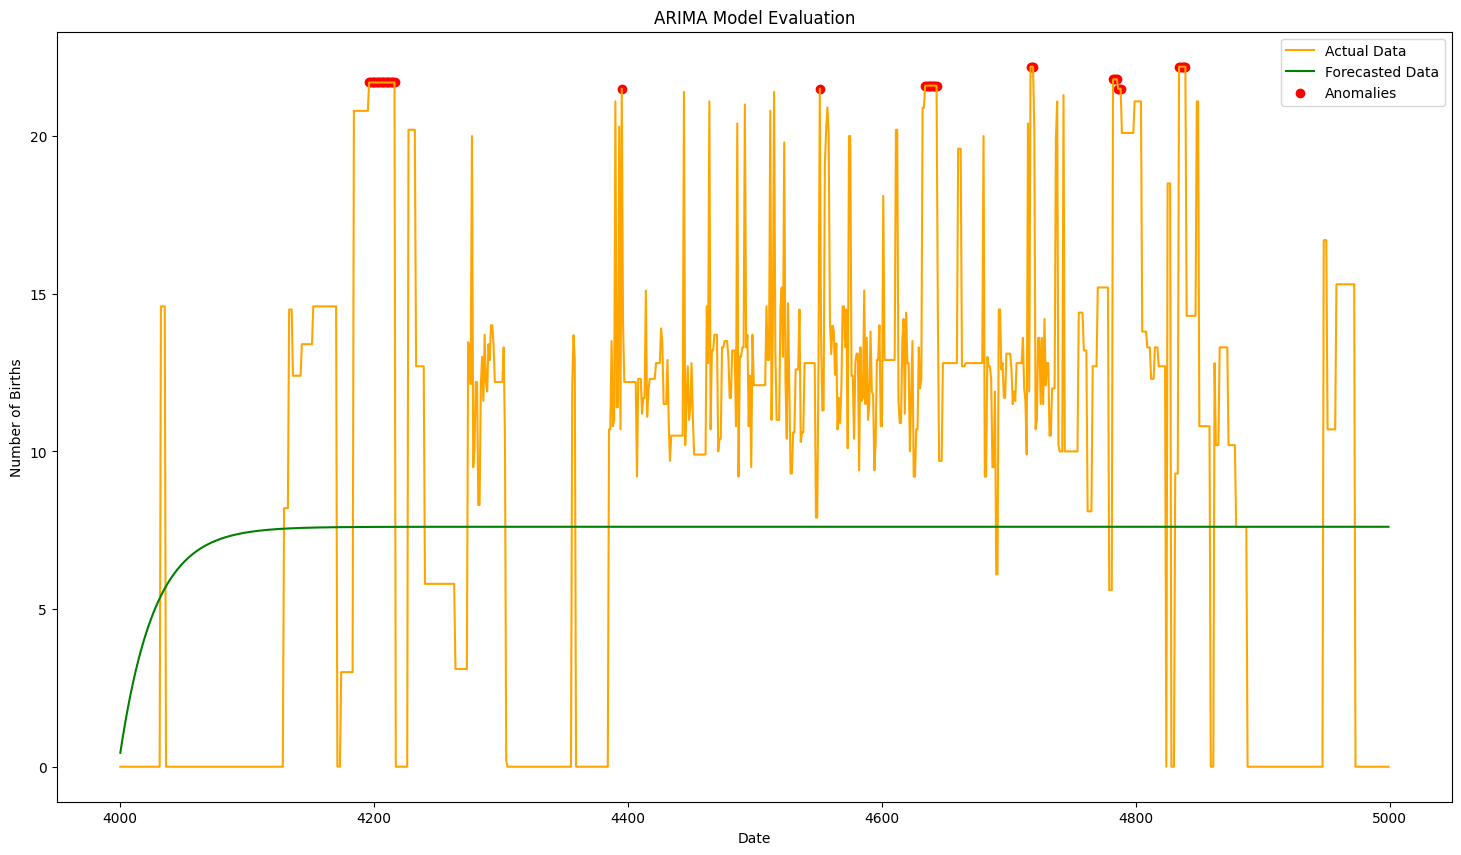

In [269]:
# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(18,10))
#plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.scatter(data_pr[data_pr['anomaly'] == 1].index, data_pr[data_pr['anomaly'] == 1]['y'], color='red', label='Anomalies', marker='o')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Prophet

In [48]:
df_prophet = pd.DataFrame()
df_prophet[['ds','y']] = df_copy_5k[['Дата/Время', 'Токовый ремни Афл3.1.Максим RMS']]
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], dayfirst=True)

In [115]:
from prophet import Prophet

In [116]:
predictions = 1000
train_df = df_prophet[:-predictions]


m = Prophet()
m.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwq970q5/63zitmna.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwq970q5/j8fza9yn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43123', 'data', 'file=/tmp/tmprwq970q5/63zitmna.json', 'init=/tmp/tmprwq970q5/j8fza9yn.json', 'output', 'file=/tmp/tmprwq970q5/prophet_model6ahtv2sg/prophet_model-20241208130702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:07:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:07:03 - cmdstanpy - INFO - Chain

In [117]:
# Предсказываем 500 секунд
future = m.make_future_dataframe(periods=predictions, freq='s')
forecast = m.predict(future)

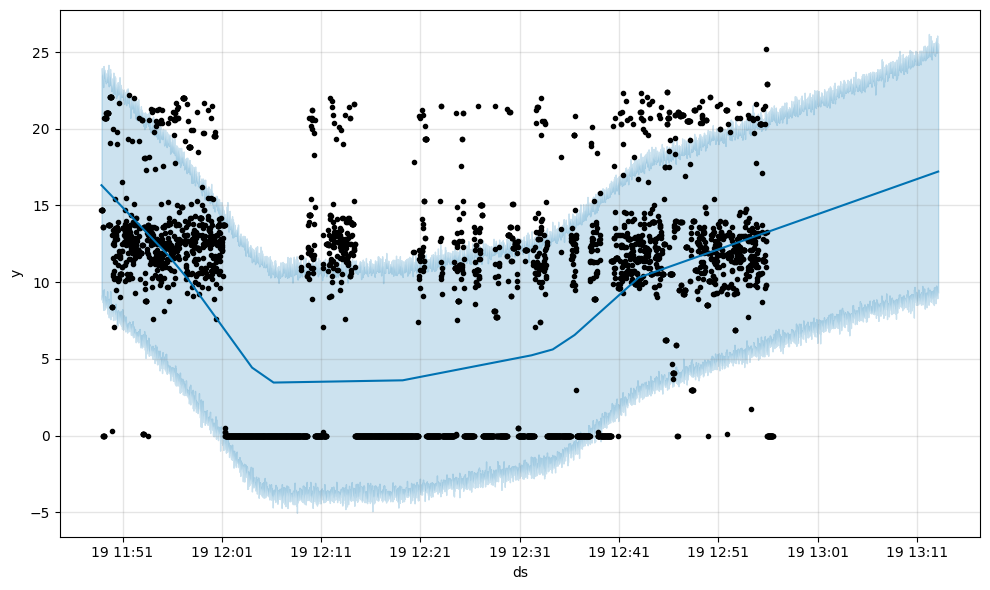

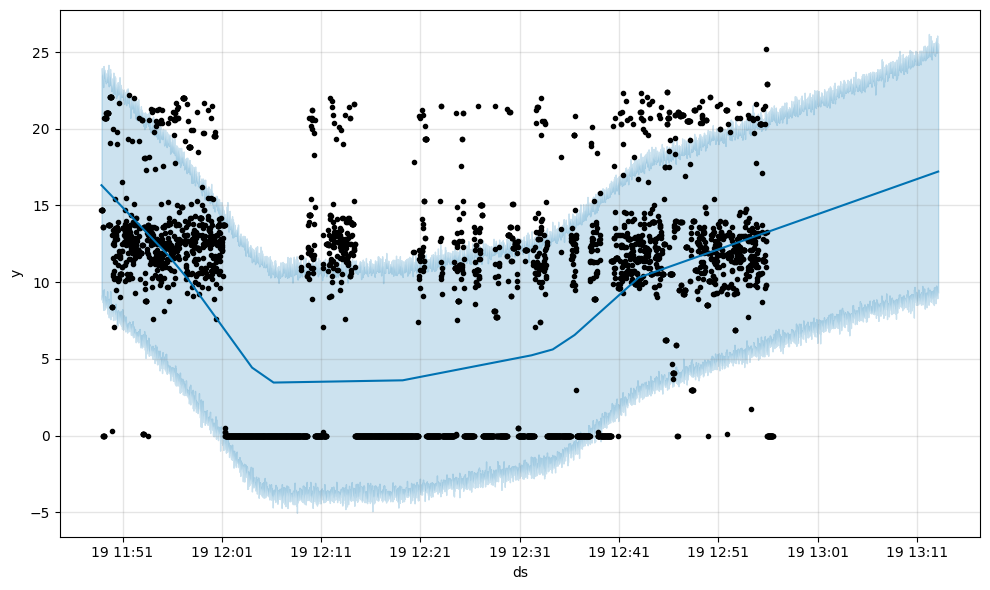

In [118]:
m.plot(forecast)

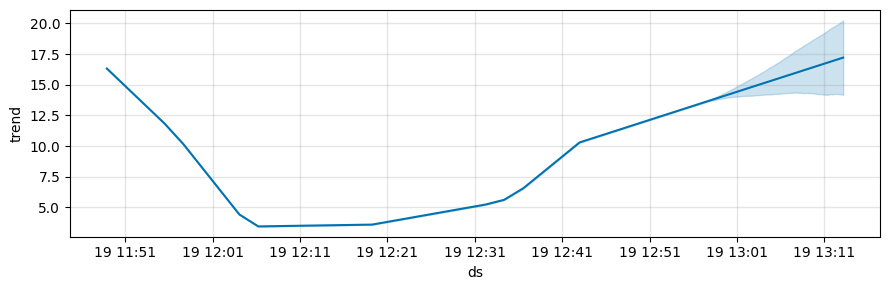

In [119]:
# Смотрим на компоненты
m.plot_components(forecast);

In [226]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_prophet.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  inf %
MAE (средняя абсолютная ошибка) –  7.406168781935979


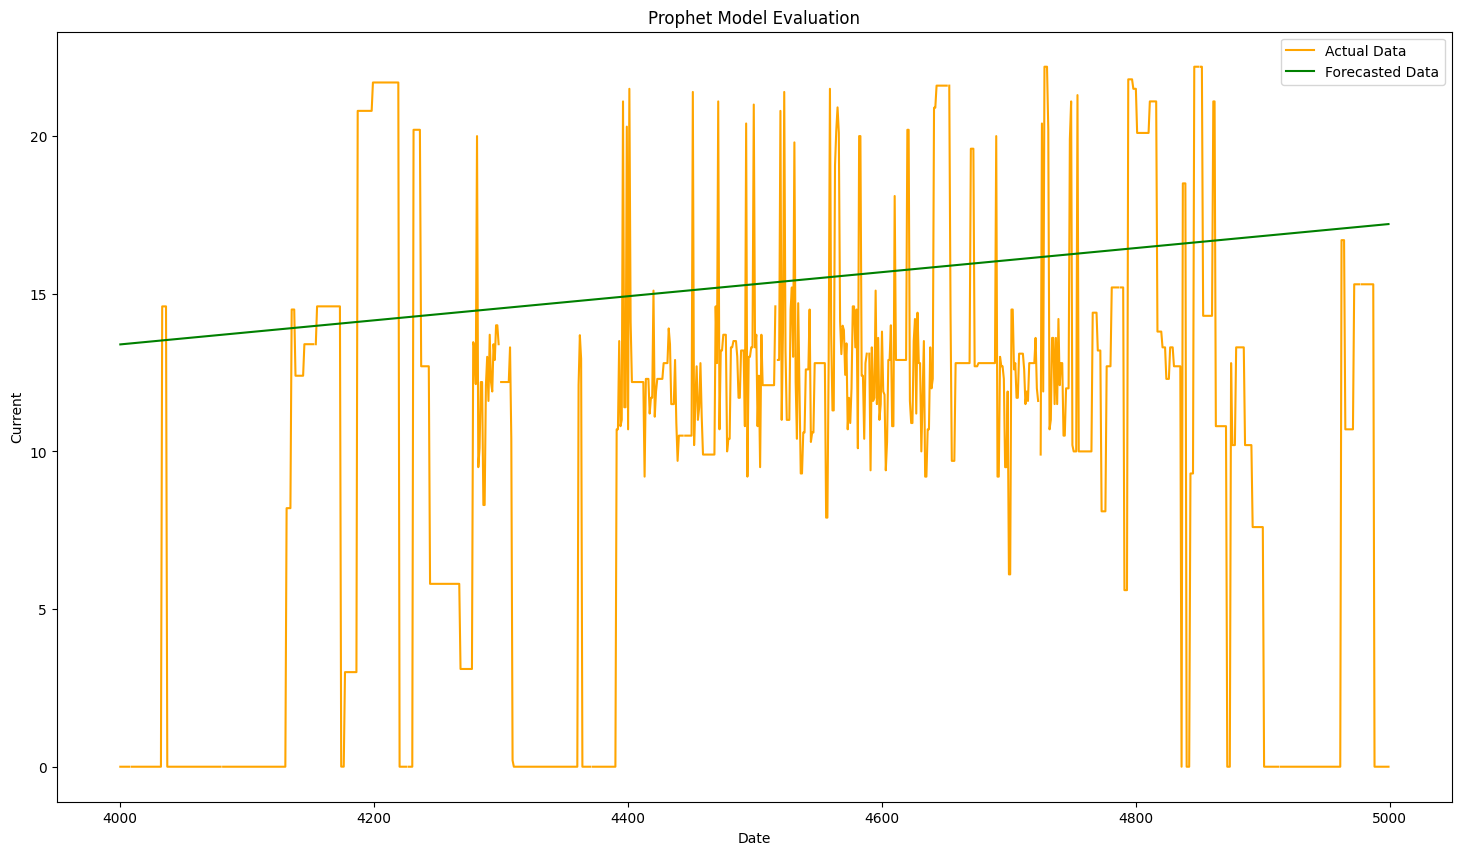

In [227]:
plt.figure(figsize=(18,10))
#plt.plot(train_df['y'], label='Training Data')
plt.plot(cmp_df['y'].reset_index()['y'][-predictions:], label='Actual Data', color='orange')
plt.plot(cmp_df['yhat'].reset_index()['yhat'][-predictions:], label='Forecasted Data', color='green')
plt.title('Prophet Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Current')
plt.legend()
plt.show()

In [228]:
# Anomaly detection (naive)
# Расхождение с моделью
# Подбор порога - ско от остатков
threshold = 2 * np.std(cmp_df['e'])

# Поиск значений выходящих за порог и отнесение в аномалии
cmp_df['anomaly'] = np.where(np.abs(cmp_df['e']) > threshold, 1, 0)


In [229]:
cmp_df = cmp_df.reset_index().reset_index()

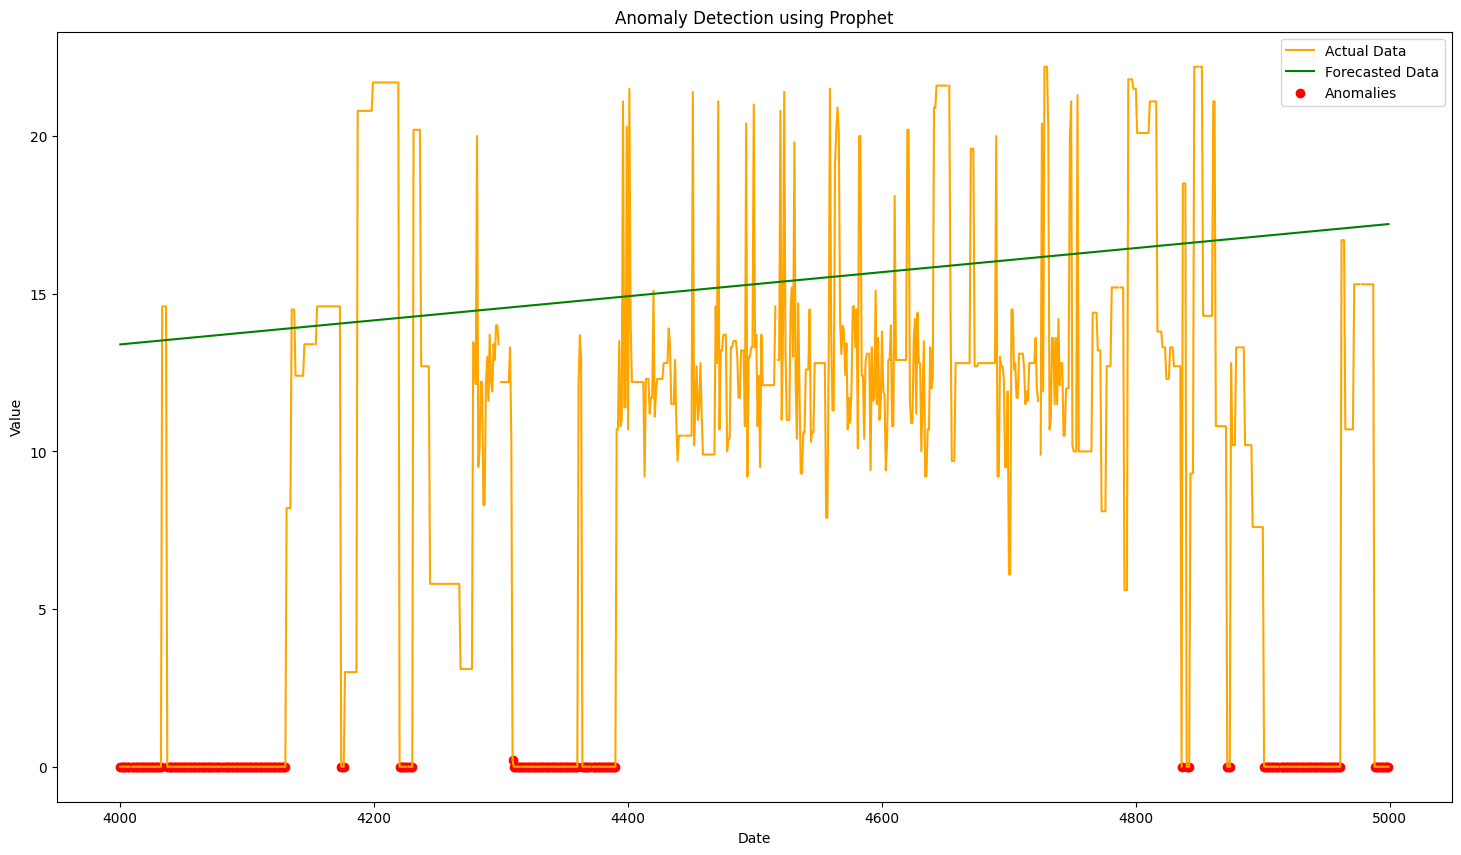

In [240]:

plt.figure(figsize=(18,10))
#plt.plot(train_df['y'], label='Training Data')
plt.plot(cmp_df['y'][-predictions:], label='Actual Data', color='orange')
plt.plot(cmp_df['yhat'][-predictions:], label='Forecasted Data', color='green')

plt.scatter(cmp_df[(cmp_df['index'] >= 4000) & (cmp_df['anomaly'] == 1)].index, cmp_df[(cmp_df['index'] >= 4000) & (cmp_df['anomaly'] == 1)]['y'], color='red', label='Anomalies', marker='o')
plt.title('Anomaly Detection using Prophet')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# LSTM-Attention

Epoch [10/100], Loss: 0.1096
Epoch [20/100], Loss: 0.0703
Epoch [30/100], Loss: 0.0619
Epoch [40/100], Loss: 0.0502
Epoch [50/100], Loss: 0.0362
Epoch [60/100], Loss: 0.0292
Epoch [70/100], Loss: 0.0275
Epoch [80/100], Loss: 0.0252
Epoch [90/100], Loss: 0.0240
Epoch [100/100], Loss: 0.0230
Train RMSE: 3.8166, Test RMSE: 4.3522


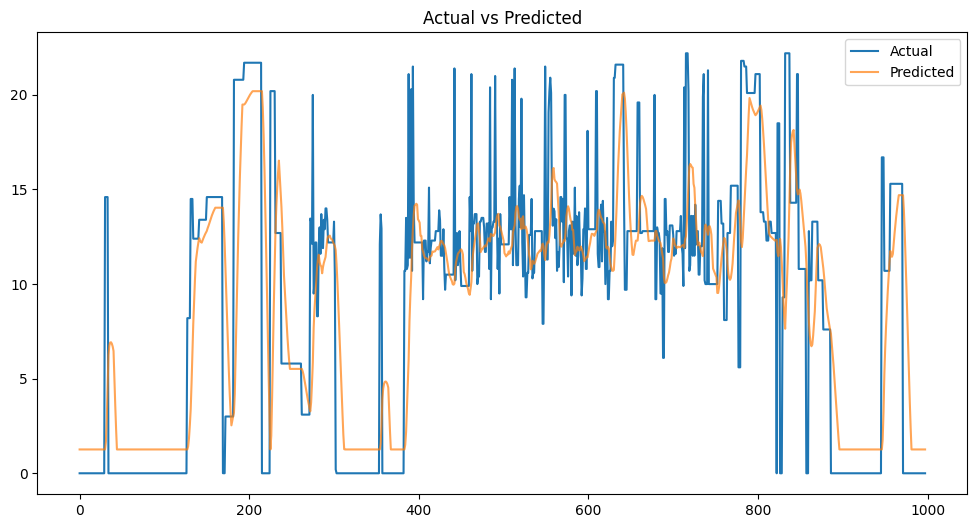

In [106]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Data loading
values = df_copy_5k['Токовый ремни Афл3.1.Максим RMS'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10  # Length of the input sequences
X, y = create_sequences(scaled_data, seq_length)

# Еraining and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Reshape tensors to 3D for LSTM (batch_size, seq_length, input_size)
X_train_tensor = X_train_tensor.view(X_train_tensor.size(0), X_train_tensor.size(1), 1)
X_test_tensor = X_test_tensor.view(X_test_tensor.size(0), X_test_tensor.size(1), 1)

# LSTM-Attention Model
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        scores = self.Va(torch.tanh(self.Wa(lstm_output) + self.Ua(lstm_output)))
        attention_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attention_weights.permute(0, 2, 1), lstm_output)
        return context, attention_weights

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMAttentionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        output = self.fc(context[:, -1, :])  # Use the last output for prediction
        return output

# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 64
output_size = 1

model = LSTMAttentionModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

# Inverse transform the predictions
y_pred_train_inverse = scaler.inverse_transform(y_pred_train.numpy())
y_pred_test_inverse = scaler.inverse_transform(y_pred_test.numpy())
y_train_inverse = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))
y_test_inverse = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inverse, y_pred_train_inverse))
test_rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_test_inverse))
print(f'Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_test_inverse, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [271]:
# Anomaly detection (naive)

In [303]:
# Создание порога на основе тренеровочных данных
train_error = y_train_inverse.flatten() - y_pred_train_inverse.flatten()
threshold = 2 * np.std(train_error)

In [304]:
# Поиск значений выходящих за порог и отнесение в аномалии тестовых данных

data_pr = pd.DataFrame()
data_pr['e_test'] = y_test_inverse.flatten() - y_pred_test_inverse.flatten()


data_pr['anomaly'] = np.where(np.abs(data_pr['e_test']) > threshold, 1, 0)
data_pr['y'] = y_test_inverse.flatten()

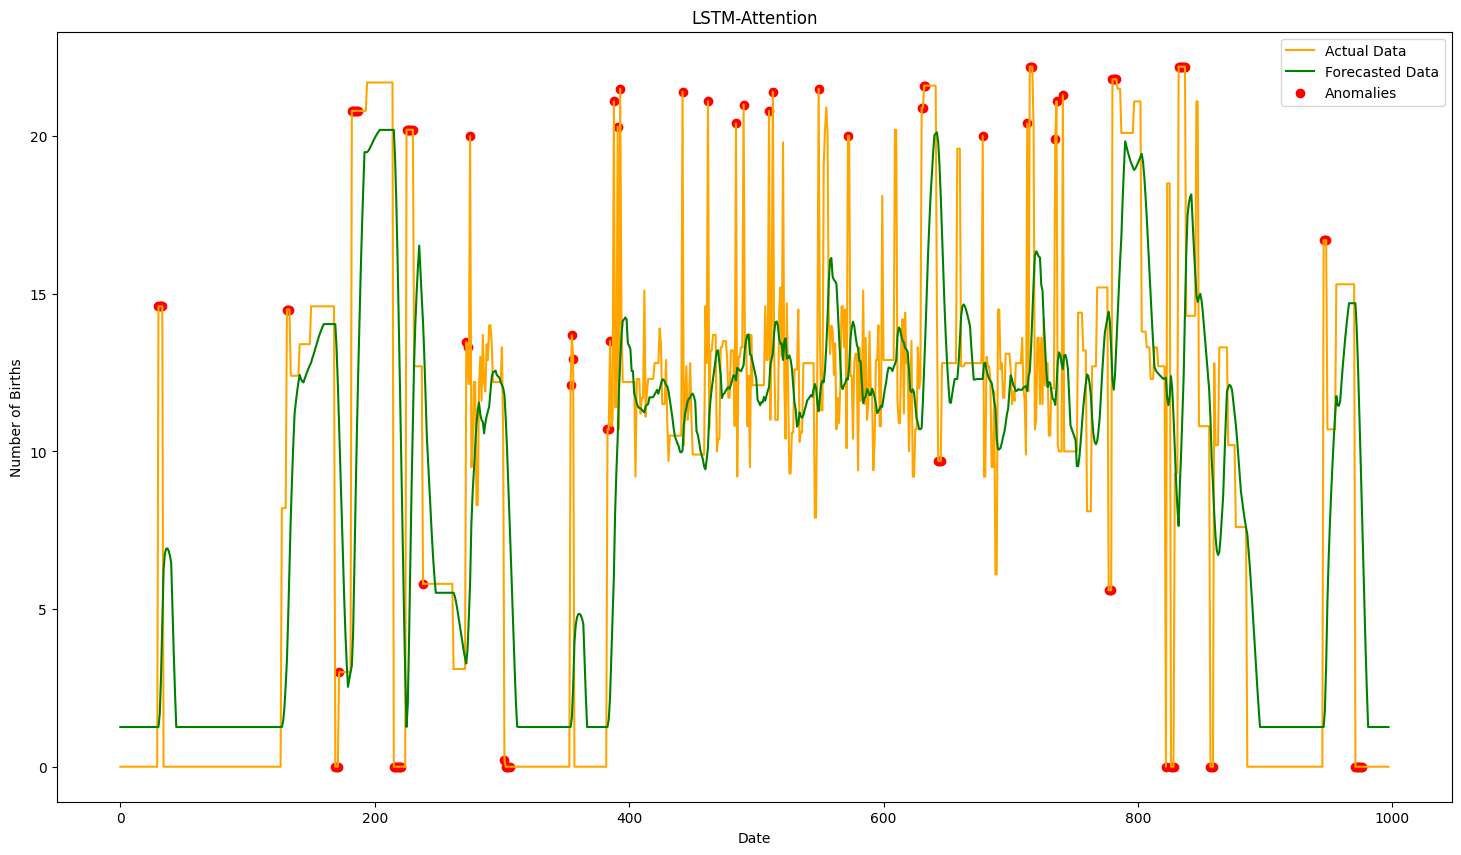

In [313]:
# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(18,10))
plt.plot(y_test_inverse, label='Actual Data', color='orange')
plt.plot(y_pred_test_inverse, label='Forecasted Data', color='green')
plt.scatter(data_pr[data_pr['anomaly'] == 1].index, data_pr[data_pr['anomaly'] == 1]['y'], color='red', label='Anomalies', marker='o')
plt.title('LSTM-Attention')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()